##Basic setup & imports

In [17]:
import os
import sys


project_root = os.getcwd()
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

print("Project root:", project_root)
print("Src path:",  src_path)

Project root: /hw6-mini-summarizer
Src path: /hw6-mini-summarizer/src


In [18]:


# Now import  modules
from dataset_utils import load_data, train_test_split
from evaluate import run_baseline_on_dataset, compute_rouge_scores, average_rouge
from model_pipeline import load_summarizer, run_model_on_dataset
from build_dataset import build_dataset, clean_text

print("Succesfully imported modules")

Succesfully imported modules


##build dataset

In [19]:
build_dataset()

Saved 250 examples to data/summarization_data.json


##Load and split data

In [20]:
data_path = "data/summarization_data.json"
examples = load_data(data_path)

len(examples), examples[0]


(250,
 {'split': 'train',
  'document': '(CNN) -- Portuguese distance runner Helder Ornelas has been handed a four-year ban after becoming the first athlete to fall foul of the IAAF\'s Biological Passport program. After abnormalities in his "blood profile" were flagged up in May 2011, the world governing body went back to scrutinize a series of blood test results for the 38-year-old between December 2009 and November 2010. Three experts in the field of haematology concluded Ornelas had used a prohibited substance or a prohibited method and the IAAF referred the case to the Portuguese Athletic Federation for adjudication. Citing "aggravating circumstances" the IAAF sought an increased four-year sanction despite it being a Ornelas\' first doping offense. Ornelas, who won the Milan Marathon in 2005 and finished eighth in the long race at the 2001 IAAF World Cross Country Championships, did not exercise his right of appeal to the Court of Arbitration for Sport. IAAF President Lamine Diack 

In [21]:
train_examples = [ex for ex in examples if ex.get("split") == "train"]
test_examples  = [ex for ex in examples if ex.get("split") == "test"]

len(train_examples), len(test_examples)


(200, 50)

##Prepare gold summaries

In [22]:
gold_summaries = [ex["summary"] for ex in test_examples]
len(gold_summaries)


50

##Run baseline on test set

In [23]:
baseline_preds = run_baseline_on_dataset(test_examples)

len(baseline_preds), baseline_preds[0]


(50, "It's a classic Australian saying: 'G'day mate, how you going?'.")

##Load the model

In [24]:
summarizer = load_summarizer(device=0)  # 0 = GPU, -1 = CPU


Device set to use cuda:0


In [25]:
#quick test
test_text = test_examples[0]["document"][:1000]  # truncate for speed
summary_example = summarizer(test_text, max_new_tokens=100, min_length=15, truncation=True)[0]["summary_text"]
summary_example


" Kieran Murray recently spent months travelling across the US and documented his interactions with locals all around the country . One man in Austin, Texas, was convinced Murray said 'Get out (of) my nightgown'"

##Run Model on full test set

In [26]:
model_preds = run_model_on_dataset(
    summarizer,
    test_examples,
    min_len=15,
    max_new_tokens=100
)

len(model_preds), model_preds[0]


(50,
 " Kieran Murray recently spent months travelling across the US and documented his interactions with locals all around the country . His latest video asks Americans to attempt the Australian accent by saying 'G'day mate, how you going?' One man in Austin, Texas was convinced Murray said 'Get out (of) my nightgown' Others erupted into fits of laughter as they tried to translate the phrase .")

In [27]:
#see example
i = 0
print("ORIGINAL DOCUMENT:\n", test_examples[i]["document"],"\n")
print("GOLD SUMMARY:\n", gold_summaries[i], "\n")
print("MODEL SUMMARY:\n", model_preds[i])


ORIGINAL DOCUMENT:
 It's a classic Australian saying: 'G'day mate, how you going?'. But when one Australian traveller tried to get American's to repeat it, many were lost for words. Kieran Murray, from Brisbane in Queensland, recently spent months travelling across the US, and documented his interactions with locals all around the country. From a homeless man who was insistent upon telling his story about Britney Spears, to a man who insisted Murray was saying 'Get out of my nightgown', the filmmaker captured it all. Scroll down for video . Aussie filmmaker Kieran Murray has released the second installment of his hilarious series which asks Americans to attempt the Australian accent by saying 'G'day mate, how you going? One man in Austin, Texas (far right) was convinced Murray said 'Get out (of) my nightgown' This is the latest in a series of videos Murray put together one of which is based around the same topic, and another of which asks people to guess what common Australian expressi

##Compute ROUGE for baseline and model

In [28]:
# Baseline ROUGE
baseline_scores = compute_rouge_scores(gold_summaries, baseline_preds)
baseline_avg = average_rouge(baseline_scores)


# Model ROUGE
model_scores = compute_rouge_scores(gold_summaries, model_preds)
model_avg = average_rouge(model_scores)


def print_rouge(name, avg):
    print(f"{name}:")
    print(f"  ROUGE-1 F: {avg['rouge1']:.4f}")
    print(f"  ROUGE-L F: {avg['rougeL']:.4f}")

print_rouge("Baseline", baseline_avg)
print_rouge("Model", model_avg)


Baseline:
  ROUGE-1 F: 0.2766
  ROUGE-L F: 0.1963
Model:
  ROUGE-1 F: 0.4372
  ROUGE-L F: 0.3162


#View graphs

In [29]:
baseline_r1 = [s["rouge1"].fmeasure for s in baseline_scores]
model_r1    = [s["rouge1"].fmeasure for s in model_scores]

len(baseline_r1), len(model_r1)

(50, 50)

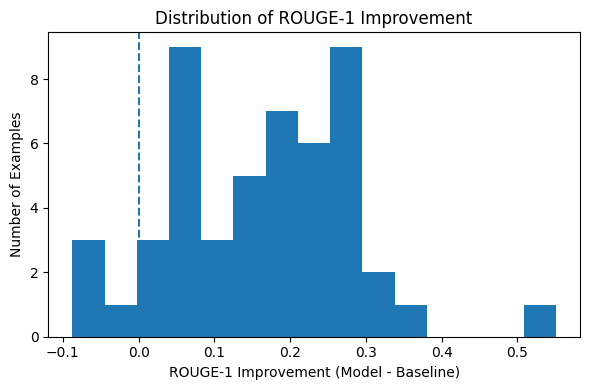

Mean improvement: 0.16061000782229765
Min improvement: -0.08745211622909466
Max improvement: 0.5507527926177757


In [30]:
import numpy as np
import matplotlib.pyplot as plt

improvements = np.array(model_r1) - np.array(baseline_r1)

plt.figure(figsize=(6, 4))
plt.hist(improvements, bins=15)

plt.xlabel("ROUGE-1 Improvement (Model - Baseline)")
plt.ylabel("Number of Examples")
plt.title("Distribution of ROUGE-1 Improvement")

plt.axvline(0.0, linestyle="--")  # zero line

plt.tight_layout()
plt.show()

print("Mean improvement:", improvements.mean())
print("Min improvement:", improvements.min())
print("Max improvement:", improvements.max())


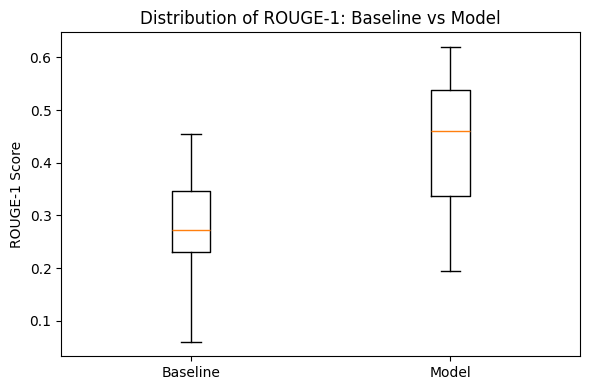

In [36]:
plt.figure(figsize=(6, 4))
plt.boxplot([baseline_r1, model_r1], tick_labels=["Baseline", "Model"])

plt.ylabel("ROUGE-1 Score")
plt.title("Distribution of ROUGE-1: Baseline vs Model")

plt.tight_layout()
plt.show()


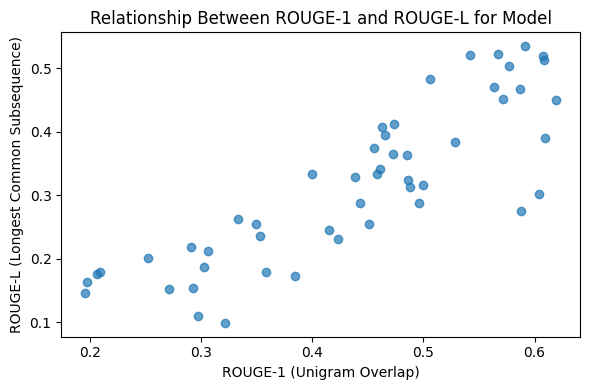

In [38]:
plt.figure(figsize=(6,4))
plt.scatter(model_r1, [s['rougeL'].fmeasure for s in model_scores], alpha=0.7)

plt.xlabel("ROUGE-1 (Unigram Overlap)")
plt.ylabel("ROUGE-L (Longest Common Subsequence)")
plt.title("Relationship Between ROUGE-1 and ROUGE-L for Model")

plt.tight_layout()
plt.show()




In [ ]:
summary_lengths = [len(pred.split()) for pred in model_preds]

plt.figure(figsize=(6,4))
plt.scatter(summary_lengths, model_r1, alpha=0.7)

plt.xlabel("Summary Length (words)")
plt.ylabel("ROUGE-1 F-measure")
plt.title("Does Summary Length Affect ROUGE-1?")

plt.tight_layout()
plt.show()


#save predictions

In [ ]:
import json

output = {
    "gold": gold_summaries,
    "baseline": baseline_preds,
    "model": model_preds,
}

with open("data/predictions.json", "w", encoding="utf-8") as f:
    json.dump(output, f, ensure_ascii=False, indent=2)

print("Saved predictions to data/predictions.json")


##Pick random Examples

In [ ]:
import random
random.seed(0)
indices = random.sample(range(len(test_examples)), 3)
indices


In [ ]:
for i in indices:
    print("=" * 80)
    print(f"Example {i}")
    print("\nDOCUMENT:\n", test_examples[i]["document"][:800], "...\n")
    print("GOLD SUMMARY:\n", gold_summaries[i], "\n")
    print("BASELINE SUMMARY:\n", baseline_preds[i], "\n")
    print("MODEL SUMMARY:\n", model_preds[i], "\n")
